In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import networkx as nx
import os

In [3]:
# Load the simulation data
datapath = "../data/weekly_release"
data = pd.read_csv(f"{datapath}/results.csv")
data = data[data['story_item'] != 0]

folders = ["weekly_release"]
prefixes = ['weekly_release']

data

,agent,timestep,story_item,adopted,prob,Narrative,Social,Trial
1,0,0,1,False,0.000000,0.000000,0.0,0
2,0,0,2,False,0.000000,0.000000,0.0,0
3,0,0,3,False,0.000000,0.000000,0.0,0
4,0,0,4,False,0.070926,0.141851,0.0,0
5,0,0,5,False,0.070926,0.141851,0.0,0
...,...,...,...,...,...,...,...,...
52499995,49,999,16,True,1.000000,1.000000,1.0,49
52499996,49,999,17,True,1.000000,1.000000,1.0,49
52499997,49,999,18,True,1.000000,1.000000,1.0,49
52499998,49,999,19,True,1.000000,1.000000,1.0,49


In [16]:
# Load the expriment data
df = pd.read_csv("../data/story_list.csv")
df

,Item,Time,Published_time,Actor(s),Event,Shares,Comments,Reactions
0,1,Late 2020,19-Sep-22,Trump,Took away WH documents,1891,1056,5757
1,2,21-Jan,26-Aug-22,Trump,Resist Returning the documents,1770,2535,2604
2,3,21-May,24-Aug-22,National Archives,Request Trump to return documents,329,29,96
3,4,22-Feb,7-Feb-22,Trump,Return some documents,1134,1723,4514
4,5,22-Feb,9-Feb-22,National Archives,Found classified documents,4479,4471,12426
5,6,22-Feb,11-Feb-22,Trump,Faced possible legal consequences,2854,1682,1957
6,7,22-Feb,25-Feb-22,House panel,Widened investigation,577,322,2909
7,8,22-Aug,8-Aug-22,FBI,Searched Trump’s Home,7128,7406,11177
8,9,22-Aug,12-Aug-22,Far right people,"Talks of war, and conspiracy",758,664,3107
9,10,22-Aug,10-Aug-22,Trump,Suggests FBI planted evidence,100,256,342


In [4]:
# Caclulate the last adoption propensity for each story structure

def read_parameters_from_file(folder_name):
    params = {}
    datapath = f"../data/{folder_name}/parameters.txt"
    with open(datapath, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            try:
                # Attempt to convert numerical values to float
                params[key] = float(value)
            except ValueError:
                # Keep string values as is
                params[key] = value
    return params

def calculate_narrative_influence(story_graph, target_node, beta, gamma, x_0, x_s):
    adopted_nodes = set(story_graph.nodes()) - {target_node}
    unscaled_W = 0
    for adopted_node in adopted_nodes:
        try:
            distance = nx.shortest_path_length(story_graph, source=target_node, target=adopted_node)
            unscaled_W += 1 / distance
        except nx.NetworkXNoPath:
            continue
    W = 1 / (1 + np.exp(-x_s * (beta + gamma * unscaled_W - x_0)))
    return W

def process_story_graph(folder_name):
    datapath = f"../data/{folder_name}/"
    with open(f"{datapath}story_graph.gpickle", 'rb') as f:
        story_graph = pickle.load(f)

    # Read parameters from file
    params = read_parameters_from_file(folder_name)

    last_adoption_propensity = {}
    for node in story_graph.nodes():
        W = calculate_narrative_influence(story_graph, node, params['beta'], params['gamma'], params['x_0'], params['x_s'])
        last_adoption_propensity[node] = W

    df = pd.DataFrame(list(last_adoption_propensity.items()), columns=['Node', 'LastAdoptionPropensity'])
    return df


for folder in folders:
    # Dynamically create variable names and assign DataFrames to them
    globals()[f"{folder}_propensity"] = process_story_graph(folder)

In [5]:
def load_data(folder_name):
    datapath = f"../data/{folder_name}/results.csv" 
    data = pd.read_csv(datapath)
    return data

def first_adoption_time(data):
    # Filter the dataframe to include only the first adoption instance of each story item by each agent across all trials
    all_trials_adopted = data[data['adopted'] == True].sort_values(by='timestep').drop_duplicates(subset=['Trial', 'agent', 'story_item'], keep='first')
    
    return all_trials_adopted

for folder in folders:
    variable_name = f"data_{folder}"  
    adoption_time_variable_name = f"adoption_time_{folder}" 
    loaded_data = load_data(folder) 
    globals()[adoption_time_variable_name] = first_adoption_time(loaded_data)

In [6]:
def preprocess_adoption_time(adoption_time_data):
    # Calculate the average time taken to adopt each story item across all trials, based on the first adoption instance
    average_time_all_trials = adoption_time_data.groupby(['Trial', 'story_item'])['timestep'].mean().reset_index()

    # Now calculate the overall average for each story item across all trials
    overall_average_time = average_time_all_trials.groupby('story_item')['timestep'].mean().reset_index()
    
    return overall_average_time

for folder in folders:
    adoption_time_variable_name = f"adoption_time_{folder}"  # Name of the variable holding the first adoption time dataframe
    preprocessed_variable_name = f"preprocessed_{folder}"  # Name for the variable to store the preprocessed data
    
    # Retrieve the adoption time dataframe from the dynamically named variable
    adoption_time_data = globals()[adoption_time_variable_name]
    
    # Preprocess the adoption time data to get the overall average time and assign it to a dynamically named variable
    globals()[preprocessed_variable_name] = preprocess_adoption_time(adoption_time_data)


In [7]:
# Merge the first adoption timestep data and the last adoption propensity

for prefix in prefixes:
    # Construct DataFrame names based on the prefix
    preprocessed_df_name = f'preprocessed_{prefix}'
    propensity_df_name = f'{prefix}_propensity'
    
    preprocessed_df = locals()[preprocessed_df_name]
    propensity_df = locals()[propensity_df_name]
    
    # Perform the merge operation
    merged_df = pd.merge(preprocessed_df, propensity_df, left_on='story_item', right_on='Node')
    merged_df = merged_df[['story_item', 'timestep', 'LastAdoptionPropensity']]
    
    # Dynamically create a variable name for the merged DataFrame
    merged_df_name = f'merged_{prefix}'
    
    # Assign the merged DataFrame to a variable with the dynamically created name
    globals()[merged_df_name] = merged_df

In [8]:
# Merge the DataFrames on 'story_item' from merged_weekly_release and 'Item' from df
final_df = pd.merge(merged_weekly_release, df, left_on='story_item', right_on='Item', how='left')

# Optionally, if you don't need the 'Item' column anymore, you can drop it
final_df.drop(columns=['Item'], inplace=True)

final_df

,story_item,timestep,LastAdoptionPropensity,Time,Published_time,Actor(s),Event,Shares,Comments,Reactions
0,1,49.635918,0.350529,Late 2020,19-Sep-22,Trump,Took away WH documents,1891,1056,5757
1,3,44.764800,0.482088,21-May,24-Aug-22,National Archives,Request Trump to return documents,329,29,96
2,4,19.997200,0.547747,22-Feb,7-Feb-22,Trump,Return some documents,1134,1723,4514
3,5,20.493878,0.669627,22-Feb,9-Feb-22,National Archives,Found classified documents,4479,4471,12426
4,6,20.660000,0.477034,22-Feb,11-Feb-22,Trump,Faced possible legal consequences,2854,1682,1957
5,7,22.633191,0.587951,22-Feb,25-Feb-22,House panel,Widened investigation,577,322,2909
6,8,42.212800,0.758230,22-Aug,8-Aug-22,FBI,Searched Trump’s Home,7128,7406,11177
7,9,44.337600,0.565988,22-Aug,12-Aug-22,Far right people,"Talks of war, and conspiracy",758,664,3107
8,10,44.067600,0.635990,22-Aug,10-Aug-22,Trump,Suggests FBI planted evidence,100,256,342
9,11,44.220000,0.565988,22-Aug,9-Aug-22,Trump,Potentially disqualified from presidential run,367,882,6229


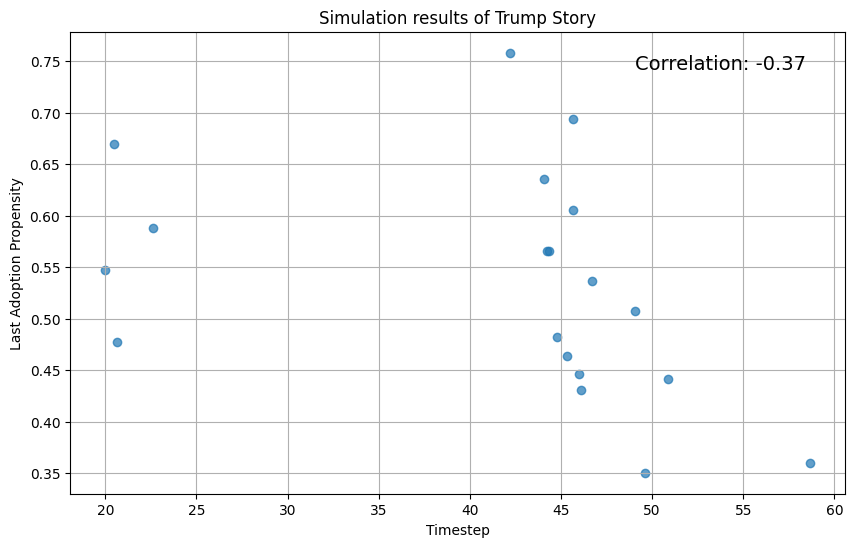

In [9]:
# Calculate the Pearson correlation coefficient
correlation = merged_weekly_release['timestep'].corr(merged_weekly_release['LastAdoptionPropensity'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(merged_weekly_release['timestep'], merged_weekly_release['LastAdoptionPropensity'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('Timestep')
plt.ylabel('Last Adoption Propensity')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

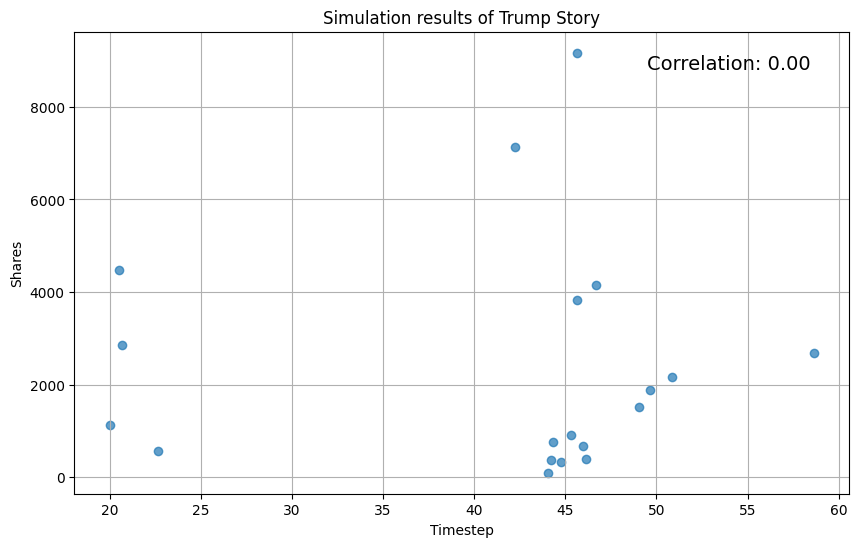

In [10]:
# Calculate the Pearson correlation coefficient
correlation = final_df['timestep'].corr(final_df['Shares'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['timestep'], final_df['Shares'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('Timestep')
plt.ylabel('Shares')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

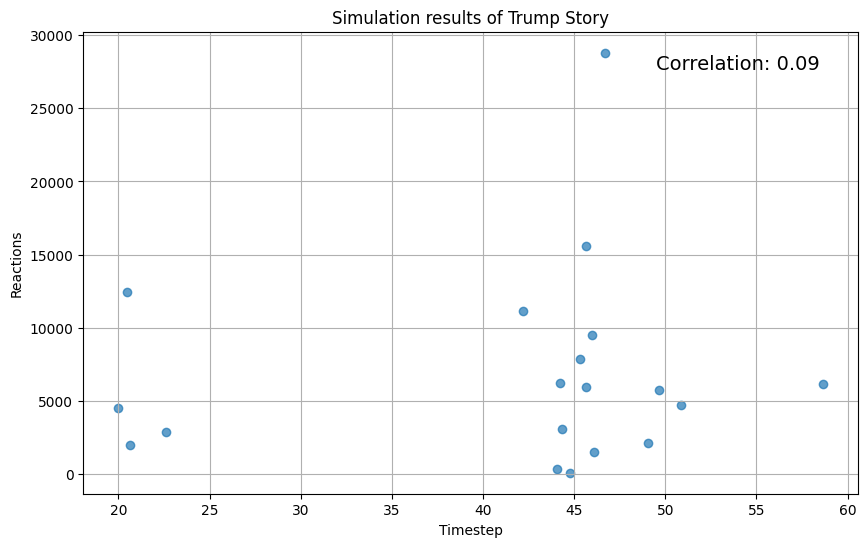

In [11]:
# Calculate the Pearson correlation coefficient
correlation = final_df['timestep'].corr(final_df['Reactions'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['timestep'], final_df['Reactions'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('Timestep')
plt.ylabel('Reactions')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

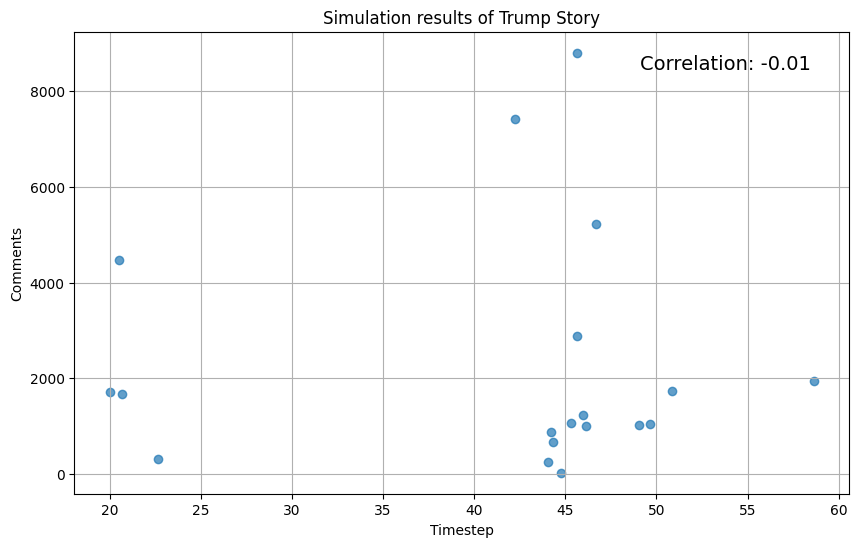

In [12]:
# Calculate the Pearson correlation coefficient
correlation = final_df['timestep'].corr(final_df['Comments'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['timestep'], final_df['Comments'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('Timestep')
plt.ylabel('Comments')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

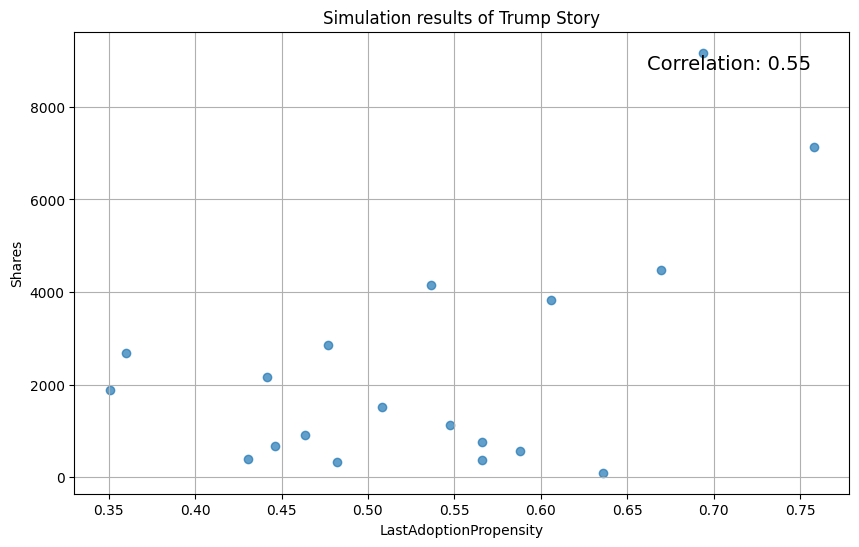

In [13]:
# Calculate the Pearson correlation coefficient
correlation = final_df['LastAdoptionPropensity'].corr(final_df['Shares'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['LastAdoptionPropensity'], final_df['Shares'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('LastAdoptionPropensity')
plt.ylabel('Shares')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

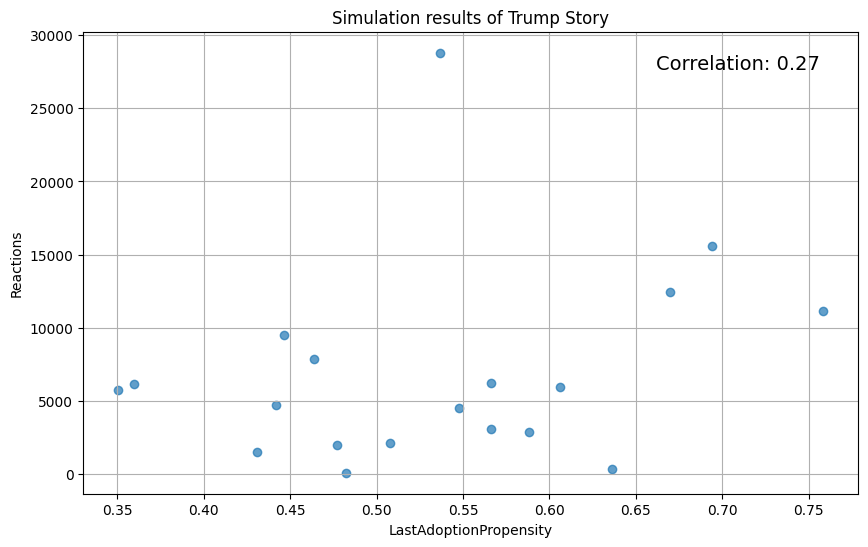

In [14]:
# Calculate the Pearson correlation coefficient
correlation = final_df['LastAdoptionPropensity'].corr(final_df['Reactions'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['LastAdoptionPropensity'], final_df['Reactions'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('LastAdoptionPropensity')
plt.ylabel('Reactions')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()

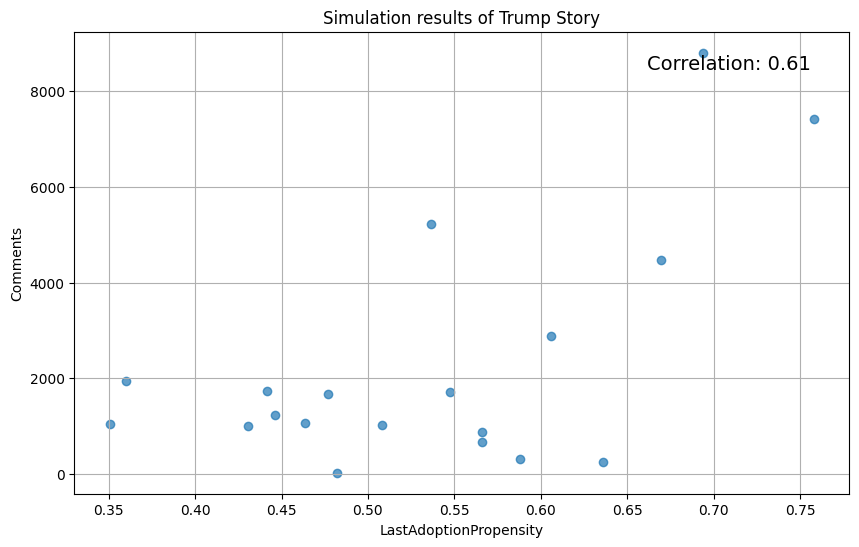

In [15]:
# Calculate the Pearson correlation coefficient
correlation = final_df['LastAdoptionPropensity'].corr(final_df['Comments'])

# Create a scatter plot of 'timestep' vs 'LastAdoptionPropensity'
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(final_df['LastAdoptionPropensity'], final_df['Comments'], alpha=0.7)
plt.title('Simulation results of Trump Story')
plt.xlabel('LastAdoptionPropensity')
plt.ylabel('Comments')
plt.grid(True)  # Add a grid

# Add the correlation value as text
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', fontsize=14, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

plt.show()